# Predicting Patient Diagnosis from Natural Language Symptoms
## AAI-501 Team 3 Final Project

Team 3 Members:  Tyler Foreman, Christi Moncrief, Tewfik Istanbooly, Mayank Bhatt

Date:  August 14, 2023

GitHub Repository: https://github.com/t4ai/AAI-501-Team3

In [86]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import statistics
import spacy
import nltk
import pickle


# SciKit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, make_scorer, f1_score, classification_report
from sklearn import preprocessing


import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import keras
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

## Exploratory Data Analysis
 
 - Load data into dataframe
 - Generate and review descriptive statistics of the dataset/variables
 - Plot visualization of data spread for each variable


In [122]:
# Load dataset
symptoms_disease_df = pd.read_csv('./Symptom2Disease.csv')
symptoms_disease_df.head()

,index,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


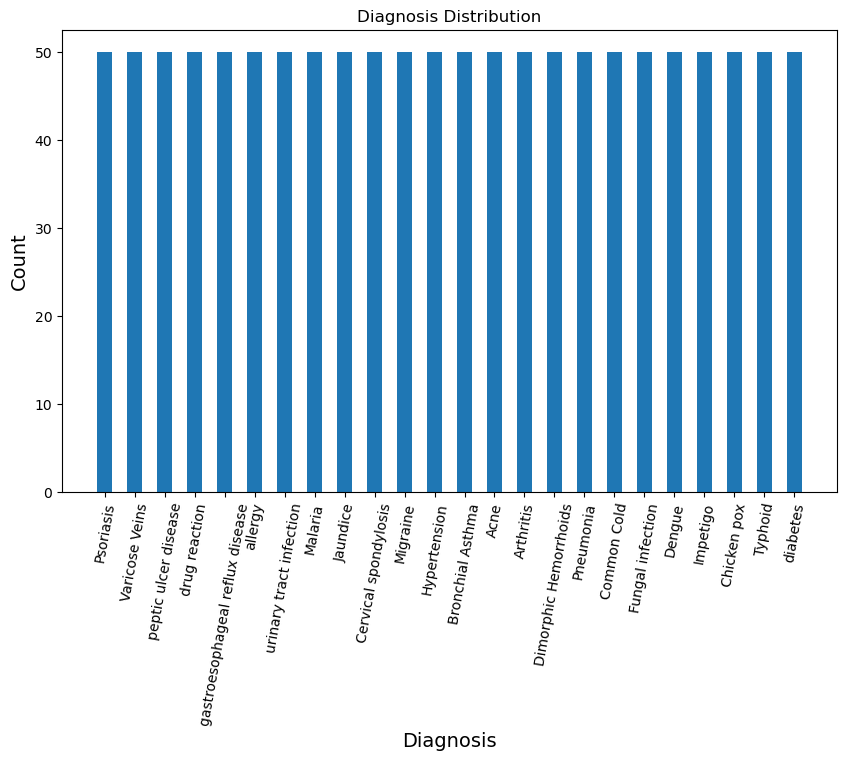

In [123]:
# plot distribution of diagnoses
fig, ax = plt.subplots(figsize=(10, 6))
categories = symptoms_disease_df['label'].value_counts().index
counts = symptoms_disease_df['label'].value_counts().values
plt.bar(categories, counts, width=0.5)

# Add labels
plt.ylabel('Count',fontsize=14)
plt.xlabel('Diagnosis',fontsize=14)
plt.xticks(fontsize=10, rotation = 80)
plt.yticks(fontsize=10)

# Add Title
plt.title('Diagnosis Distribution',fontsize=12);
plt.show()

## Data Cleanup
-  Perform routine cleanup on data:
    - remove punctuation marks
    - convert to lowercase
    - remove numbers
    - remove whitespace
- Remove stop words
- Lemmatize the text
    - Normalize to base words

In [ ]:
# remove punctuation marks
punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
symptoms_disease_df['text'] = symptoms_disease_df['text'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punctuation)))

# convert text to lowercase
symptoms_disease_df['text'] = symptoms_disease_df['text'].str.lower()

# remove numbers
symptoms_disease_df['text'] = symptoms_disease_df['text'].str.replace("[0-9]", " ")

# remove whitespaces
symptoms_disease_df['text'] = symptoms_disease_df['text'].apply(lambda x:' '.join(x.split()))

symptoms_disease_df['text'].head()

In [93]:
# remove stop words
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')
symptoms_disease_df['text'] = symptoms_disease_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
symptoms_disease_df['text'].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerforeman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    experiencing skin rash arms, legs, torso past ...
1    skin peeling, especially knees, elbows, scalp....
2    experiencing joint pain fingers, wrists, knees...
3    silver like dusting skin, especially lower bac...
4    nails small dents pits them, often feel inflam...
Name: text, dtype: object

##### Lemmatization helper functions



In [ ]:
# Lemmatize to normalize words - use only for Embeddings below
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# function to lemmatize symptoms text
def lemmatization(symptoms):
    output = []
    for i in symptoms:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

## Data Preparation
-  Split data into test/train/validate datasets (80/10/10)
-  Create 3 datasets for experimentation:
    1.  Vectorize natrual language text using TFIDF
    2.  Create embeddings using Word2Vec (older approach)
    3.  Create embeddings using ELMo (Embeddings from Language Models)
- For each of the above, ensure no data leakage by separating train/test
    


In [95]:
# extract symptom description text to df X (features)
X = symptoms_disease_df['text'].copy()

# extract diagnosis into df for y (labels)
y_raw = symptoms_disease_df['label'].copy()


In [96]:
# Helper functions for one-hot encode/decode for labels (y)
def encode(en, labels):
    enc = en.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(en, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return en.inverse_transform(dec)

# one hot encode y
encoder = preprocessing.LabelEncoder()
encoder.fit(y_raw)

np.asarray(y).shape

(1200, 24)

In [125]:
# Split dataset into train, validate, test
X_train, X_test_val, y_train, y_test_val = train_test_split(X, np.asarray(y_raw), test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

In [134]:
# Create one-hot ecoded vectors for y (for NN model)
y_train_enc = encode(encoder, y_train)
y_val_enc = encode(encoder, y_val)
y_test_enc = encode(encoder, y_test)

### Prepare TF-IDF Vectorized datasets

In [139]:
# Copy datasets for lemmatization
X_train_lemm = X_train.copy()
X_val_lemm = X_val.copy()
X_test_lemm = X_test.copy()

# Lemmatize the datasets
X_train_lemm = pd.Series(lemmatization(X_train_lemm))
X_val_lemm = pd.Series(lemmatization(X_val_lemm))
X_test_lemm = pd.Series(lemmatization(X_test_lemm))

In [151]:
# Start with count vecotrizer to build vocabulary - fit on train data first
count_vectorizer = CountVectorizer()

# Vectorize training data to create bag of words - fit the vectorizor on the training set only to avoid data leakage
X_train_count = count_vectorizer.fit_transform(X_train)
X_train_count.shape

# Vectorize test and validation data
X_val_count = count_vectorizer.transform(X_val)
X_test_count = count_vectorizer.transform(X_test)

# Fit tfidf vectorizer on training count only to avoid data leakage
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_count)

# Vectorize training, val, test data to TFIDF
X_train_tfidf = tf_transformer.transform(X_train_count)
X_val_tfidf = tf_transformer.transform(X_val_count)
X_test_tfidf = tf_transformer.transform(X_test_count)


### Setup ELMo Embeddings Helper Functions

In [68]:
# Load pre trained ELMo model
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

In [114]:

# ELMo Embedding - use as embedding layer in NN
def elmo_embedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

def get_elmo_batches(dataset, batch_size):
  return [dataset[i:i+batch_size] for i in range(0,len(dataset),batch_size)]

# save generated embedding to pickle file
def save_embedding(embedding, file_name):
  # save elmo_train_new
  pickle_out = open(file_name,"wb")
  pickle.dump(embedding, pickle_out)
  pickle_out.close()

# load previously generated embedding from pickle file
def load_saved_embedding(file_name):
  pickle_in = open(file_name, "rb")
  return pickle.load(pickle_in)

# use for generating stand alone embeddings (ie: to train shallow classifiers)
def elmo_preprocess_embeddings(x):
  embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))


In [104]:
# Copy datasets for elmo
X_train_elmo = X_train.copy()
X_val_elmo = X_val.copy()
X_test_elmo = X_test.copy()

# Lemmatize the datasets
X_train_elmo = pd.Series(lemmatization(X_train_elmo))
X_val_elmo = pd.Series(lemmatization(X_val_elmo))
X_test_elmo = pd.Series(lemmatization(X_test_elmo))

In [120]:
# peek at the lemmatized data
print(X_train.values[2])
print(X_train_elmo.values[2])

standing walking long periods time causing lot pain legs. feels like cramp becomes worse longer feet.
stand walk long period time cause lot pain leg . feel like cramp become worse long foot .


## Model Training and Tuning
-  Run two experiments with different model architectures and data preparation:
    -  Experiment 1: Train a Naive Bayes Classifier usin TF-IDF vectorized features
    -  Experiment 2: Train a neural network classifier with an ELMo text embedding
-  For each experiment:
    -  Train the model on each experimental dataset
    -  Validate against validation dataset
    -  Tune hyperparameters as necessary to optimize performance
    -  Repeat until optimized
    -  Measure model performance

### Experiment 1: Train Naive Bayes Classifer on Vectorized data

In [154]:
# Initialize Naive Bayes Classifier
clf1 = MultinomialNB()

# Train classifier
clf1.fit(X_train_tfidf, y_train)

MultinomialNB()

In [155]:
# get score
score_val = clf1.score(X_val_tfidf, y_val)
print("Accuracy score: {}".format(round(score_val, 4)))

Accuracy score: 0.9417


In [178]:
# run predictions and display report
predictions = clf1.predict(X_val_tfidf)
print(classification_report(y_val, predictions))

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         6
                      Arthritis       1.00      1.00      1.00         7
               Bronchial Asthma       1.00      1.00      1.00         5
           Cervical spondylosis       1.00      1.00      1.00         2
                    Chicken pox       0.83      0.83      0.83         6
                    Common Cold       1.00      1.00      1.00         6
                         Dengue       0.83      0.83      0.83         6
          Dimorphic Hemorrhoids       0.80      1.00      0.89         4
               Fungal infection       1.00      1.00      1.00        11
                   Hypertension       1.00      1.00      1.00         2
                       Impetigo       1.00      1.00      1.00         3
                       Jaundice       1.00      1.00      1.00         7
                        Malaria       0.88      1.

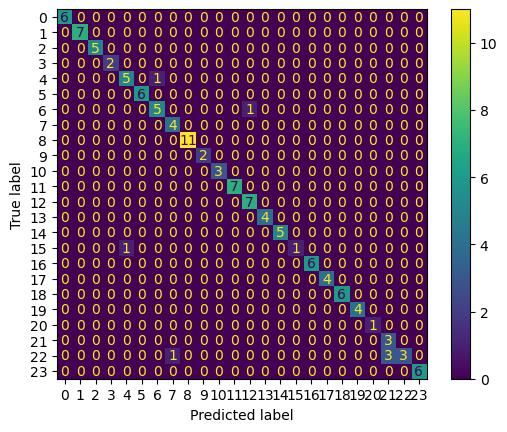

In [133]:
# plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, predictions)).plot();

#### Confusion Matrix Classes:
[0:Acne], [1:Arthritis], [2:Bronchial Asthma], [3:Cervical spondylosis], [4:Chicken pox], [5:Common Cold], [6:Dengue], [7:Dimorphic Hemorrhoids], [8:Fungal infection], [9:Hypertension], [10:Impetigo], [11:Jaundice], [12:Malaria], [13:Migraine], [14:Pneumonia], [15:Psoriasis], [16:Typhoid], [17:Varicose Veins], [18:allergy], [19:diabetes], [20:drug reaction], [21:gastroesophageal reflux disease], [22:peptic ulcer disease]

### Experiment 2: Train Neural Network Classifier with ELMo Embeddings

#### Define Model Architecture and Train
Define a model with a text input layer feeding into ELMo embedding layer, one additional hidden layer and an output layer predicting the 24 classes (diagnoses).  Once trained, weights are saved to a file so training is not necessary every run. 

Note: this step is only necessary for model re-training

In [105]:
# Build Model
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(elmo_embedding, output_shape=(1024, ))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(24, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(X_train_elmo, y_train_enc, epochs=20, batch_size=16)
    model.save_weights('./weights/symptoms-elmo-model-lemm.h5')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 960 samples
Epoch 1/20
960/960 [==============================] - 162s 169ms/sample - loss: 2.3820 - accuracy: 0.3750
Epoch 2/20
960/960 [==============================] - 151s 157ms/sample - loss: 1.1768 - accuracy: 0.7312
Epoch 3/20
960/960 [==============================] - 148s 154ms/sample - loss: 0.6733 - accuracy: 0.8635
Epoch 4/20
960/960 [==============================] - 147s 153ms/sample - loss: 0.4390 - accuracy: 0.9281
Epoch 5/20
960/960 [==============================] - 1075s 1s/sample - loss: 0.2991 - accuracy: 0.9521
Epoch 6/20
960/960 [==============================] - 1482s 2s/sample - loss: 0.2060 - accuracy: 0.9750
Epoch 7/20
960/960 [==============================] - 583s 607ms/sample - loss: 0.1499 - accuracy: 0.9896
Epoch 8/20
960/960 [==============================] - 167s 174ms/sample - loss: 0.1072 - accuracy: 0.9979
Epoch 9/20
960/960 [==============================] - 177s 184ms/sample - loss: 0.0853 - accuracy: 0.9979
Epoch 10/20
960/960 [========

dict_keys(['loss', 'accuracy'])


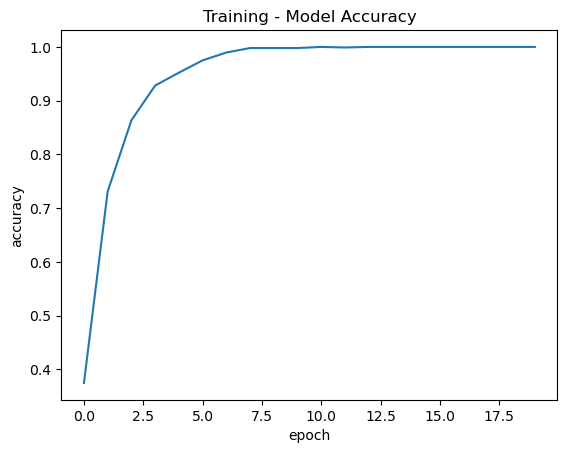

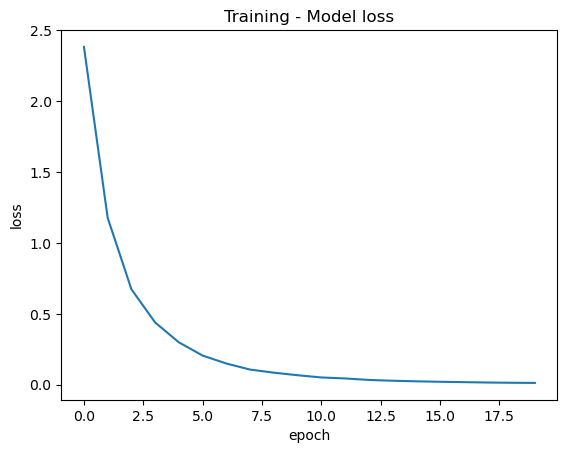

In [121]:
# visualize training progression

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Training - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Training - Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Helper fuctions for running experiment result analysis

In [179]:
def run_elmo_predictions(X):
    with tf.Session() as session:
        K.set_session(session)
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
        model.load_weights('./weights/symptoms-elmo-model-lemm.h5')  
        return model.predict(X, batch_size=16)

def run_elmo_report(y_in, predictions):
    # decode validation labels
    y_in_dec = decode(encoder, y_in)

    # decode predicted labels
    y_preds_dec = decode(encoder, predictions)

    print(classification_report(y_in_dec, y_preds_dec))

def run_confusion_matrix_elmo(y_in, predictions):
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_in, predictions)).plot();

#### Assess model with validation data
With the trained model, run against validation dataset and measure performance.  Note, we have done two training runs - one with non-Lemmatized data and one with Lemmatized data.  The weight files are as follows, load the approrpate one:

- Lemmatized Input Data: symptoms-elmo-model-lemm.h5
- Non-Lemmatized Input Data: symptoms-elmo-model.h5



In [169]:
# Run model on validation dataset
val_predictions = run_elmo_predictions(X_val_elmo)

In [170]:
# Display classification report
run_elmo_report(y_val_enc, val_predictions)

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         6
                      Arthritis       1.00      1.00      1.00         7
               Bronchial Asthma       1.00      1.00      1.00         5
           Cervical spondylosis       1.00      1.00      1.00         2
                    Chicken pox       1.00      0.83      0.91         6
                    Common Cold       1.00      0.83      0.91         6
                         Dengue       1.00      0.67      0.80         6
          Dimorphic Hemorrhoids       1.00      1.00      1.00         4
               Fungal infection       1.00      1.00      1.00        11
                   Hypertension       1.00      1.00      1.00         2
                       Impetigo       0.75      1.00      0.86         3
                       Jaundice       1.00      1.00      1.00         7
                        Malaria       1.00      1.

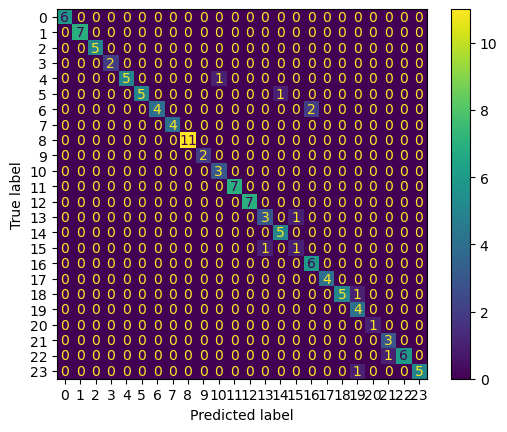

In [174]:
# plot the confusion matrix
run_confusion_matrix_elmo(y_val, decode(encoder, val_predictions))

#### Confusion Matrix Classes:
[0:Acne], [1:Arthritis], [2:Bronchial Asthma], [3:Cervical spondylosis], [4:Chicken pox], [5:Common Cold], [6:Dengue], [7:Dimorphic Hemorrhoids], [8:Fungal infection], [9:Hypertension], [10:Impetigo], [11:Jaundice], [12:Malaria], [13:Migraine], [14:Pneumonia], [15:Psoriasis], [16:Typhoid], [17:Varicose Veins], [18:allergy], [19:diabetes], [20:drug reaction], [21:gastroesophageal reflux disease], [22:peptic ulcer disease]

## Model Comparison and Selection

- Test both models against test dataset
- Compare model performance

#### Assess NBC model with test data
With the trained model, run against test dataset and measure performance.  


In [184]:
# get score
score_test = clf1.score(X_test_tfidf, y_test)
print("[Test] Accuracy score: {}".format(round(score_test, 4)))

[Test] Accuracy score: 0.9667


In [185]:
# run predictions and display report
nbc_test_predictions = clf1.predict(X_test_tfidf)
print(classification_report(y_test, nbc_test_predictions))

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         1
                      Arthritis       1.00      1.00      1.00         3
               Bronchial Asthma       1.00      1.00      1.00         6
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       1.00      1.00      1.00         6
                    Common Cold       1.00      1.00      1.00         6
                         Dengue       1.00      1.00      1.00         6
          Dimorphic Hemorrhoids       0.75      1.00      0.86         3
               Fungal infection       1.00      1.00      1.00         2
                   Hypertension       1.00      1.00      1.00         8
                       Impetigo       1.00      1.00      1.00         8
                       Jaundice       1.00      1.00      1.00         4
                        Malaria       0.80      1.

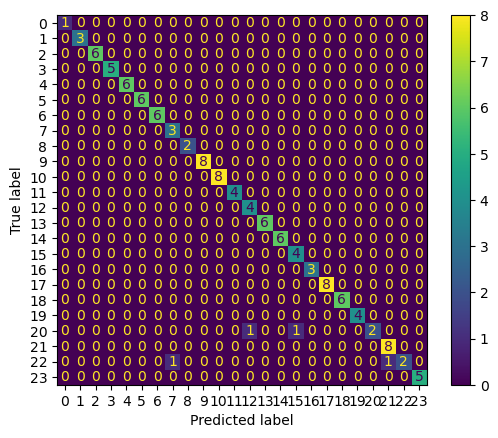

In [186]:
# plot the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, nbc_test_predictions)).plot();

#### Assess ELMo model with test data
With the trained model, run against test dataset and measure performance.  Note, we have done two training runs - one with non-Lemmatized data and one with Lemmatized data.  The weight files are as follows, load the approrpate one:


In [175]:
# Run model on validation dataset
test_predictions = run_elmo_predictions(X_test_elmo)

In [180]:
# Display classification report
run_elmo_report(y_test_enc, test_predictions)

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         1
                      Arthritis       1.00      1.00      1.00         3
               Bronchial Asthma       1.00      1.00      1.00         6
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       1.00      0.67      0.80         6
                    Common Cold       0.86      1.00      0.92         6
                         Dengue       0.71      0.83      0.77         6
          Dimorphic Hemorrhoids       1.00      1.00      1.00         3
               Fungal infection       1.00      1.00      1.00         2
                   Hypertension       1.00      0.88      0.93         8
                       Impetigo       1.00      1.00      1.00         8
                       Jaundice       1.00      1.00      1.00         4
                        Malaria       1.00      1.

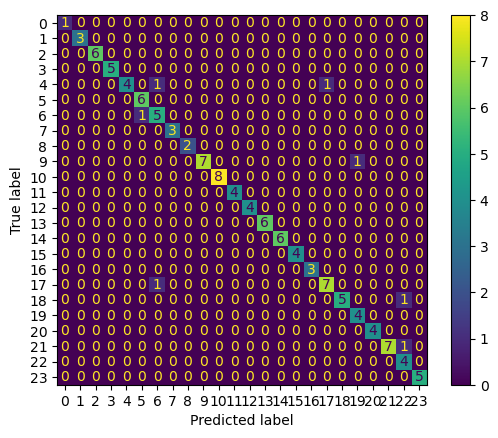

In [181]:
# plot the confusion matrix
run_confusion_matrix_elmo(y_test, decode(encoder, test_predictions))